# Chebyshev Usage Examples

This notebook shows off some of what the `cheb_deriv` function can do.

## Setup

First imports and a foundational calculation of cosine-spaced points, which will be reused throughout.

In [1]:
import sys; sys.path.append('../specderiv') # so I can import specderiv code from a neighboring working directory
from specderiv import cheb_deriv
import numpy as np
from matplotlib import pyplot
import time

$$ x_n = \cos\!\big(\frac{\pi}{N}n\big), \quad n \in \{0, ... N\}$$

In [2]:
N = 20
x_n = np.cos(np.arange(N+1) * np.pi / N) # length N+1, in keeping with the usage of N in Trefethen.
x = np.linspace(-1, 1, 100) # A denser set of points over the domain, for plotting

Using cosine-spaced points allows us to use the DCT to get in and out of the basis domain, thereby incurring a cost of only $O(N \log N)$.

## Derivatives in 1D

The most basic thing this package accomplishes is taking derivatives. It's useful to look at what it calculates in 1D against a known answer. Here I'm testing against the function $e^x \sin(5 x)$, which has some interesting wiggles on $[-1, 1]$, is easy to differentiate analytically, and *isn't* periodic.

I've gone all the way up to the $6^{th}$ derivative, because it's beyond what I calculated by hand.

execution ms: 1.5709400177001953


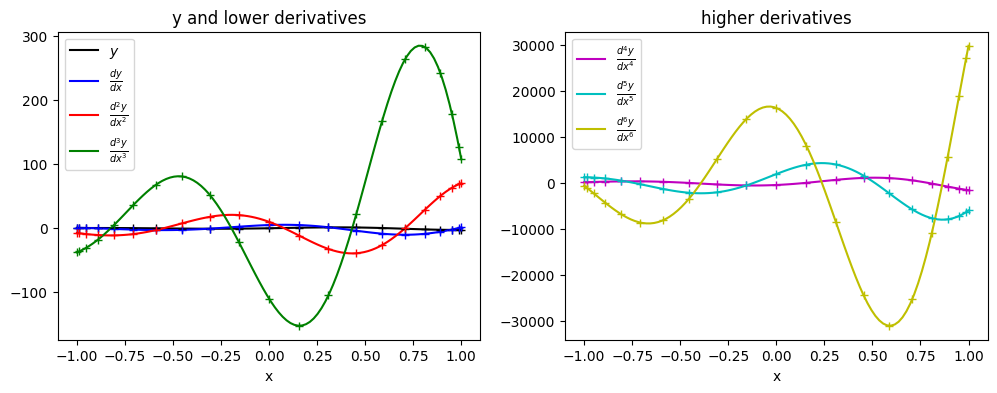

In [3]:
# You can evaluate these with WolframAlpha or by hand.
y = np.exp(x) * np.sin(5*x)
dy = 5*np.exp(x) * np.cos(5*x) + y
d2y = 2*np.exp(x) * (5*np.cos(5*x) - 12*np.sin(5*x))
d3y = -2*np.exp(x) * (37*np.sin(5*x) + 55*np.cos(5*x))
d4y = 4*np.exp(x) * (119*np.sin(5*x) - 120*np.cos(5*x))
d5y = 4*np.exp(x) * (719*np.sin(5*x) + 475*np.cos(5*x))
d6y = 8*np.exp(x) * (2035*np.cos(5*x) - 828*np.sin(5*x))

# I'm breaking these apart across two subplots, because the scale gets enormous
# for higher derivatives and obscures what's happening for the lower ones.
fig, axes = pyplot.subplots(1, 2, figsize=(12,4))
axes[0].plot(x, y, 'k', label="$y$")
axes[0].plot(x, dy, 'b', label=r"$\frac{dy}{dx}$")
axes[0].plot(x, d2y, 'r', label=r"$\frac{d^2y}{dx^2}$")
axes[0].plot(x, d3y, 'g', label=r"$\frac{d^3y}{dx^3}$")
axes[0].set_title("y and lower derivatives")
axes[0].set_xlabel('x')
axes[0].legend()
axes[1].plot(x, d4y, 'm', label=r"$\frac{d^4y}{dx^4}$")
axes[1].plot(x, d5y, 'c', label=r"$\frac{d^5y}{dx^5}$")
axes[1].plot(x, d6y, 'y', label=r"$\frac{d^6y}{dx^6}$")
axes[1].set_title("higher derivatives")
axes[1].set_xlabel('x')
axes[1].legend()

y_n = np.exp(x_n) * np.sin(5*x_n)
before = time.time()
dy_n = cheb_deriv(y_n, x_n, 1)
d2y_n = cheb_deriv(y_n, x_n, 2)
d3y_n = cheb_deriv(y_n, x_n, 3)
d4y_n = cheb_deriv(y_n, x_n, 4)
d5y_n = cheb_deriv(y_n, x_n, 5)
d6y_n = cheb_deriv(y_n, x_n, 6)
print("execution ms:", (time.time() - before)*1000)

axes[0].plot(x_n, y_n, 'k+')
axes[0].plot(x_n, dy_n, 'b+')
axes[0].plot(x_n, d2y_n, 'r+')
axes[0].plot(x_n, d3y_n, 'g+')
axes[1].plot(x_n, d4y_n, 'm+')
axes[1].plot(x_n, d5y_n, 'c+')
axes[1].plot(x_n, d6y_n, 'y+');

As you can see, the discrete points are bang on the line, at least at this level of magnification. Let's get a real measure of how close they are using Mean Squared Error.

In [4]:
# Evaluations of the analytic answers at the x_n
df_n = 5*np.exp(x_n) * np.cos(5*x_n) + y_n
d2f_n = 2*np.exp(x_n) * (5*np.cos(5*x_n) - 12*np.sin(5*x_n))
d3f_n = -2*np.exp(x_n) * (37*np.sin(5*x_n) + 55*np.cos(5*x_n))
d4f_n = 4*np.exp(x_n) * (119*np.sin(5*x_n) - 120*np.cos(5*x_n))
d5f_n = 4*np.exp(x_n) * (719*np.sin(5*x_n) + 475*np.cos(5*x_n))
d6f_n = 8*np.exp(x_n) * (2035*np.cos(5*x_n) - 828*np.sin(5*x_n))

for i,(truth,computed) in enumerate(zip([df_n, d2f_n, d3f_n, d4f_n, d5f_n, d6f_n], [dy_n, d2y_n, d3y_n, d4y_n, d5y_n, d6y_n])):
    print("%sth derivative MSE:" % (i+1), np.mean((truth - computed)**2))

1th derivative MSE: 8.947085271317894e-20
2th derivative MSE: 1.939375907736132e-15
3th derivative MSE: 3.098259043763205e-11
4th derivative MSE: 1.9529749319026313e-07
5th derivative MSE: 0.0006294374755944416
6th derivative MSE: 1.1964277324847286


The MSEs are quite low, getting higher for higher derivatives, but remaining very small relative to the scales of the respective functions.

So hooray; it works.

### Using Arbitrary Points Instead of Cosine-Spaced

It is possible to fit Chebyshev polynomials to any points you like by solving a least squares problem in $O(N^3)$. `cheb_deriv` allows you to do this but warns you about it.

execution ms: 7.053136825561523


/Users/pavel/Code/spectral-derivatives/notebooks/../specderiv/specderiv.py:50: UserWarning: Your function is not sampled for the DCT-I, i.e. using `t_n = np.cos(np.arange(N+1) * np.pi / N) * (b - a)/2 + (b + a)/2`.
			`cheb_deriv` using chebfit() and chebval() under the hood, which costs O(N^3) instead of O(N log N).
  warn("""Your function is not sampled for the DCT-I, i.e. using `t_n = np.cos(np.arange(N+1) * np.pi / N) * (b - a)/2 + (b + a)/2`.


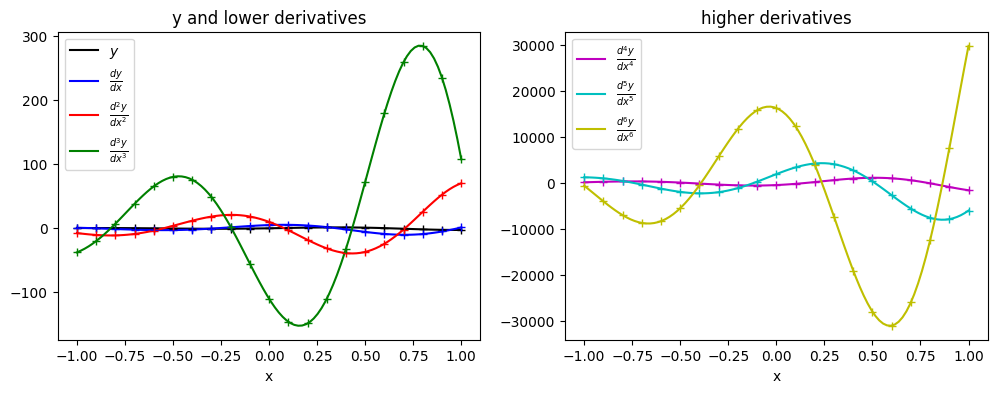

1th derivative MSE: 2.9973661019442313e-15
2th derivative MSE: 1.5548931917931587e-11
3th derivative MSE: 3.491441695430827e-08
4th derivative MSE: 4.8803788521016955e-05
5th derivative MSE: 0.04791950350106305
6th derivative MSE: 34.948920937554945


In [5]:
x_u = np.linspace(-1, 1, N+1, endpoint=True) # u for uniformly sampled

y_u = np.exp(x_u) * np.sin(5*x_u)
before = time.time()
dy_u = cheb_deriv(y_u, x_u, 1)
d2y_u = cheb_deriv(y_u, x_u, 2)
d3y_u = cheb_deriv(y_u, x_u, 3)
d4y_u = cheb_deriv(y_u, x_u, 4)
d5y_u = cheb_deriv(y_u, x_u, 5)
d6y_u = cheb_deriv(y_u, x_u, 6)
print("execution ms:", (time.time() - before)*1000)

fig, axes = pyplot.subplots(1, 2, figsize=(12,4))
axes[0].plot(x, y, 'k', label="$y$")
axes[0].plot(x, dy, 'b', label=r"$\frac{dy}{dx}$")
axes[0].plot(x, d2y, 'r', label=r"$\frac{d^2y}{dx^2}$")
axes[0].plot(x, d3y, 'g', label=r"$\frac{d^3y}{dx^3}$")
axes[0].set_title("y and lower derivatives")
axes[0].set_xlabel('x')
axes[0].legend()
axes[1].plot(x, d4y, 'm', label=r"$\frac{d^4y}{dx^4}$")
axes[1].plot(x, d5y, 'c', label=r"$\frac{d^5y}{dx^5}$")
axes[1].plot(x, d6y, 'y', label=r"$\frac{d^6y}{dx^6}$")
axes[1].set_title("higher derivatives")
axes[1].set_xlabel('x')
axes[1].legend()
axes[0].plot(x_u, y_u, 'k+')
axes[0].plot(x_u, dy_u, 'b+')
axes[0].plot(x_u, d2y_u, 'r+')
axes[0].plot(x_u, d3y_u, 'g+')
axes[1].plot(x_u, d4y_u, 'm+')
axes[1].plot(x_u, d5y_u, 'c+')
axes[1].plot(x_u, d6y_u, 'y+')
pyplot.show()

# Evaluations of the analytic answers at the x_u
df_u = 5*np.exp(x_u) * np.cos(5*x_u) + y_u
d2f_u = 2*np.exp(x_u) * (5*np.cos(5*x_u) - 12*np.sin(5*x_u))
d3f_u = -2*np.exp(x_u) * (37*np.sin(5*x_u) + 55*np.cos(5*x_u))
d4f_u = 4*np.exp(x_u) * (119*np.sin(5*x_u) - 120*np.cos(5*x_u))
d5f_u = 4*np.exp(x_u) * (719*np.sin(5*x_u) + 475*np.cos(5*x_u))
d6f_u = 8*np.exp(x_u) * (2035*np.cos(5*x_u) - 828*np.sin(5*x_u))

for i,(truth,computed) in enumerate(zip([df_u, d2f_u, d3f_u, d4f_u, d5f_u, d6f_u],
                                        [dy_u, d2y_u, d3y_u, d4y_u, d5y_u, d6y_u])):
    print("%sth derivative MSE:" % (i+1), np.mean((truth - computed)**2))

Notice the accuracy of this method also takes a hit, because finding coefficients by least squares isn't as precise as by DCT.

## Derivatives in 2D

Let's work with some higher-dimensional data.

First let's define a function. I'm using $y(x_1, x_2) = x_1^2 \sin(\frac{3\pi}{2} x_2)$, because it's easy to differentiate analytically, not periodic on $x_1, x_2 \in [-1, 1]$ (i.e. the function doesn't match up cleanly at opposite bounds), and interesting to look at.

In [6]:
X1, X2 = np.meshgrid(x, x) # a 100 x 100 grid

y = X1**2 * np.sin(3/2*np.pi*X2)

Now let's take some multidimensional derivatives, $\frac{d^2}{dx_1 dx_2}$ and the Laplacian, $\nabla^2 = \frac{d^2}{dx_1^2} + \frac{d^2}{dx_2^2}$.

In [7]:
dx1dx2y = 3*X1*np.pi*np.cos(3/2*np.pi*X2) # d^2 / dx_1 dx_2
Laplacian = 2*np.sin(3/2*np.pi*X2) - 9/4*np.pi**2 * X1**2 * np.sin(3/2*np.pi*X2)

Now let's use `cheb_deriv` to find these same objects. Note we have to resample the function at cosine-spaced points to get started.

In [8]:
X1_n, X2_n = np.meshgrid(x_n, x_n) # same shapes as X1 and X2, but cosine spacing
y_n = X1_n**2 * np.sin(3/2*np.pi*X2_n) # y sampled at the cosine-spaced points

### Breaking Multidimensional into 1D Subproblems

Note this isn't the recommended way to use the function. For that see [the next section](#Single-Calls-per-Dimension). This section is just meant to prove breaking the problem up is valid.

Since all the transforms used in `cheb_deriv` are linear, and differentiation itself is linear, we can accomplish this by looping over all vectors in the data.

In [9]:
d2y_n = np.zeros((N+1, N+1))
for i in range(N+1): # iterate first dimension, taking derivatives along second dimension
	d2y_n[i] = cheb_deriv(y_n[i], x_n, 1)
for j in range(N+1): # iterate second dimension, taking derivatives along the first
	d2y_n[:,j] = cheb_deriv(d2y_n[:,j], x_n, 1)

Laplacian_n = np.zeros((N+1, N+1))
for i in range(N+1): # iterate first dimension, taking derivatives along second dimension
	Laplacian_n[i] += cheb_deriv(y_n[i], x_n, 2)
for j in range(N+1): # iterate second dimension, taking derivatives along the first 
	Laplacian_n[:,j] += cheb_deriv(y_n[:,j], x_n, 2)

And now plot it all together. The shaded curve is the densely-sampled true function, and the wireframe represents the sparser samples `cheb_deriv` takes and produces.

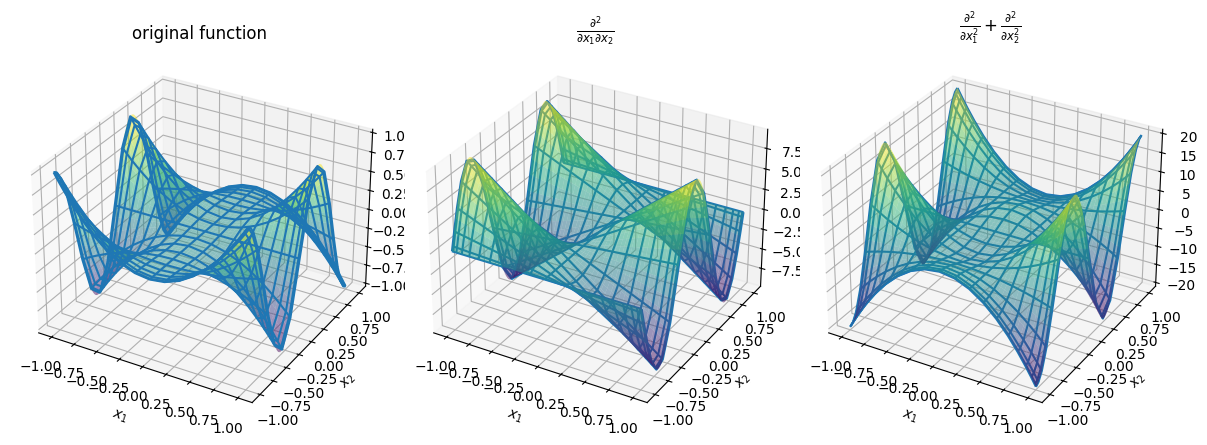

In [10]:
def plot_3d(F_n, L_n): # Put in a function, because I'll have to call this more than once.
    fig = pyplot.figure(figsize=(12, 5))
    ax1 = fig.add_subplot(1, 3, 1, projection='3d')
    ax1.plot_surface(X1, X2, y, cmap='viridis', alpha=0.5)
    ax1.set_title('original function')
    ax1.set_xlabel(r'$x_1$')
    ax1.set_ylabel(r'$x_2$')
    ax2 = fig.add_subplot(1, 3, 2, projection='3d')
    ax2.plot_surface(X1, X2, dx1dx2y, cmap='viridis', alpha=0.5)
    ax2.set_title(r'$\frac{\partial^2}{\partial x_1 \partial x_2}$')
    ax2.set_xlabel(r'$x_1$')
    ax2.set_ylabel(r'$x_2$')
    ax3 = fig.add_subplot(1, 3, 3, projection='3d')
    ax3.plot_surface(X1, X2, Laplacian, cmap='viridis', alpha=0.5)
    ax3.set_title(r'$\frac{\partial^2}{\partial x_1^2} + \frac{\partial^2}{\partial x_2^2}$')
    ax3.set_xlabel(r'$x_1$')
    ax3.set_ylabel(r'$x_2$')

    ax1.plot_wireframe(X1_n, X2_n, y_n)
    ax2.plot_wireframe(X1_n, X2_n, F_n)
    ax3.plot_wireframe(X1_n, X2_n, L_n)

    pyplot.tight_layout()

plot_3d(d2y_n, Laplacian_n)

All matches! Great!

### Single Calls per Dimension

Fundamentally, looping over a bunch of 1D vectors has to happen somewhere, but it's more convenient for us and efficient (due to `numpy`'s acceleration, not due to fundamental time complexity) to push that loop downward. [This is actually the best we can do in terms of simplicity and computational cost](https://github.com/pavelkomarov/spectral-derivatives/issues/2).

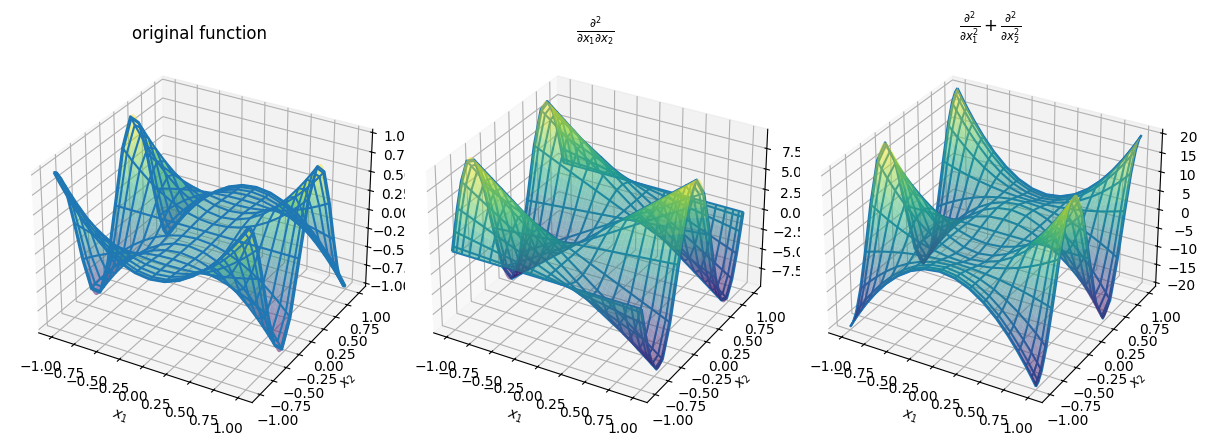

In [11]:
d2y_n = cheb_deriv(cheb_deriv(y_n, x_n, 1, axis=0), x_n, 1, axis=1) # One-lineable!
Laplacian_n = cheb_deriv(y_n, x_n, 2, axis=0) + cheb_deriv(y_n, x_n, 2, axis=1) # One-lineable!

plot_3d(d2y_n, Laplacian_n)

It looks exactly the same as before, which is what we want.

## Simulating a PDE

Now let's do a full on simulation, following [Program 20 in Trefethen](https://epubs.siam.org/doi/epdf/10.1137/1.9780898719598.ch8), except in way fewer lines.

We have:

$$ u_{tt} = u_{xx} + u_{yy} \ , \ -1 \leq x, y \leq 1 \ , \ u = 0 \ \ \text{on the boundary}$$

with initial data

$$ u(x, y, 0) = e^{-40((x - 0.4)^2 + y^2)} \ , \ u_t(x, y, 0) = 0$$

  0%|          | 0/97 [00:00<?, ?it/s]

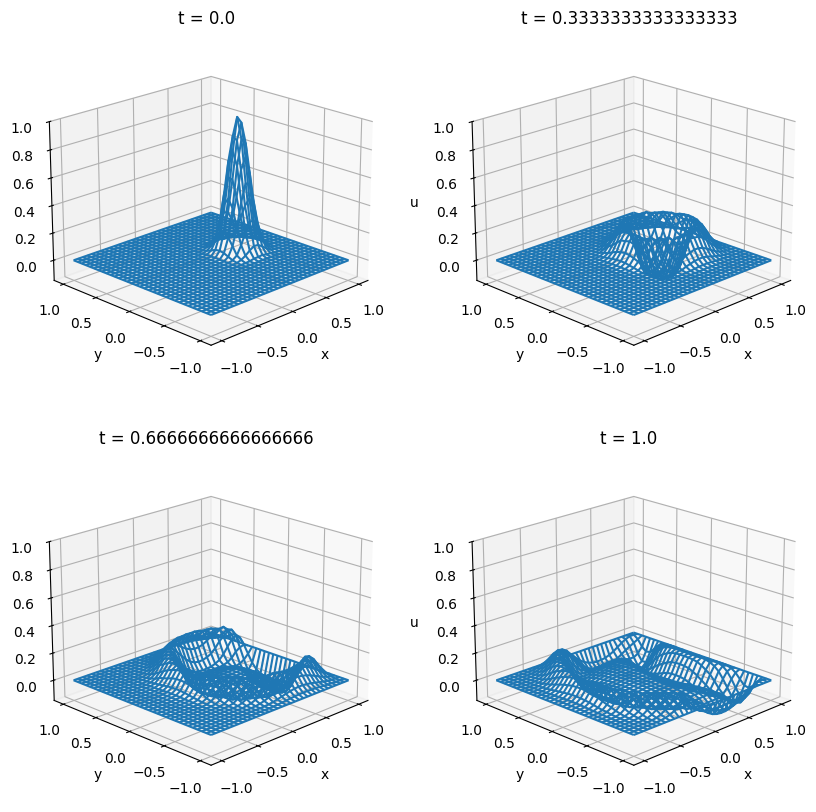

In [12]:
from scipy.interpolate import griddata
from tqdm.notebook import tqdm

N = 24
x_n = np.cos(np.linspace(0, N, N+1) * np.pi / N)
x_plot = np.arange(-1, 1 + 1/16, 1/16)

X_n, Y_n = np.meshgrid(x_n, x_n) # formerly xx and yy
X_plot, Y_plot = np.meshgrid(x_plot, x_plot)
points = np.stack([X_n.ravel(), Y_n.ravel()], -1) # shape (N, 2) in 2d, needed for griddata()

dt = 6/(N**2) # around the order of dt we want
plotgap = int((1/3)/dt) # plot every third of a second, which is this many dts

u = [np.exp(-40*((X_n - 0.4)**2 + Y_n**2))] # Keep all time slices for animation and leapfrog

fig = pyplot.figure(figsize=(10, 10))
for n in tqdm(range(0, 3*plotgap + 1)):
    t = n*dt
    if n % plotgap == 0: # plots at multiples of t=1/3
        ax = fig.add_subplot(2, 2, n//plotgap + 1, projection='3d')
        u_plot = griddata(points, u[-1].ravel(), (X_plot, Y_plot), method='cubic')
        ax.plot_wireframe(X_plot, Y_plot, u_plot)
        ax.set_zlim((-0.15, 1))
        ax.view_init(elev=20, azim=-135)
        ax.set_title('t = ' + str(t))
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('u')
    
    rhs = cheb_deriv(u[-1], x_n, 2, axis=0) + cheb_deriv(u[-1], x_n, 2, axis=1) # righthand side of PDE
    rhs[:,0] = 0; rhs[:,-1] = 0; rhs[0, :] = 0; rhs[-1,:] = 0 # pin the boundary to 0 (hence no need to calculate endpoints above)

    if n == 0:
        u.append(u[-1] + (dt**2)*rhs) # on first iteration u_old is meant to be u, so 2u - 1u = 1u
    else:
        u.append(2*u[-1] - u[-2] + (dt**2)*rhs) # leapfrog update

Interestingly, since `cheb_deriv` is capable of calculating the value of the second derivative on the boundary, I initially did *not* pin the boundary to 0. However, this causes a blowup, beginning at the edges, which ruins the simulation. This is not not due to any feature of the 2D derivative (which is correct), nor `dt` too large. Rather, it is due to the fundamental nature of differential equations: A time-evolving system needs boundary conditions, otherwise it's unclear how the system of interest we're simulating should interact with its implicit surroundings.

Take the simpler example of the heat equation in a 1D rod. We can know the initial distribution of heat, but *over time* as we simulate, if we don't know how heat is supposed to enter or exit this system from the ends (e.g. by specifying the ends are held at a certain temperature or that heat is perfectly reflected back in or perfectly radiated out), then uncertainty in the heat distribution will creep in from the ends. It turns out that, [just as the solutions to ODEs without boundary conditions contain arbitrary constants, solutions to PDEs without boundary conditions contain arbitrary *functions*!](https://math.stackexchange.com/a/2301561/278341)

In other words, boundary conditions are a way to bottle up the whole rest of the universe and treat it as a simple *interface* to our system of interest. The above simulation's boundaries being set to 0 can be thought of as the boundary being a perfect muffle for any incoming wave, which isolates the system completely from the outside world.

### Saving as an Animation

To help diagnose exactly when and where the blowup originates, or to just see the simulation in its full glory, it's cool to render all plots as a video. To do this in `matplotlib` you have to use the `FuncAnimation` class, which I find a bit odd (Just let me append frames to a list and save from there.) but workable. 

In [13]:
from matplotlib.animation import FuncAnimation, FFMpegWriter

stage, ax = pyplot.subplots(figsize=(8, 8), subplot_kw={"projection": "3d"})
ax.view_init(elev=20, azim=-135)
def draw(n):
    u_plot = griddata(points, u[n].ravel(), (X_plot, Y_plot), method='cubic')
    ax.cla() # clear before next plot
    ax.set_title(f't = {n*dt:.3f}')
    ax.set_zlim((-0.15, 1))
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('u')
    ax.plot_wireframe(X_plot, Y_plot, u_plot)

animator = FuncAnimation(stage, draw, tqdm(range(len(u)))) # https://github.com/matplotlib/matplotlib/issues/29384
pyplot.close()
animator.save('wave.mp4', writer=FFMpegWriter(fps=10))

  0%|          | 0/98 [00:00<?, ?it/s]

Now let's see it!

In [14]:
from IPython.display import Video
Video("wave.mp4", embed=True)

If you're viewing this on GitHub, I didn't upload the video, so you'll have to run locally to see it. You'll need `ffmpeg` installed.